# PAIP challenge submission

This code expects the data from the PAIP challenge split into patches. The code to generate these patches is included in a separate notebook.
The patch dataset used is availabe on Google Drive if required, it required some editing of an external to make it compatible with the PAIP dataset making it difficult to share here.

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [3]:
import os
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.utils import first
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, CacheDataset
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
    EnsureChannelFirstd,
    RandRotated,
    RandFlipd,
    RandZoomd,
    NormalizeIntensityd,
    AsChannelFirstd,
    ScaleIntensityd,
    ToTensord
)
from monai.utils import set_determinism

import torchvision.models as models
import torch.nn as nn
from collections import Counter


## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
directory = '/content/drive/MyDrive/ML/PAIP/'
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content/drive/MyDrive/ML/PAIP/


## Read slide patches

This code expects a directoy containing all the available for all the slides, with their label set as the last number before the file extension e.g filename_2.png or filename_3.png.

In [6]:
images = os.listdir(f'{directory}/patches')
len(images)

22884

In [7]:
images[:5]

['Col_PNI2021chall_train_0025_26_34_0.png',
 'Col_PNI2021chall_train_0025_29_34_0.png',
 'Col_PNI2021chall_train_0025_34_34_0.png',
 'Col_PNI2021chall_train_0025_31_34_0.png',
 'Col_PNI2021chall_train_0025_32_34_0.png']

In [8]:
labels = [int(x[-5]) for x in images]
len(labels)

22884

In [9]:
labels[:5]

[0, 0, 0, 0, 0]

Show a breakdown of the number of patches for each label

In [10]:
print(Counter(labels).keys()) # List of labels in descending frequency order
print(Counter(labels).values()) # Number of elements for each label in descending order


dict_keys([0, 3, 4, 1, 2])
dict_values([21206, 843, 580, 245, 10])


The below list of dictionarys links each input image to it's corresponding label. This format is used later by the MONAI library for loading and transforming the data for the model.
We first create a list of all the data we have, and the next step we split it into train, test and validation sets.

In [11]:
data_dicts = [{"image": f'{root_dir}/patches/{image_name}', "label": label} for image_name, label in zip(images, labels)]

In [12]:
val_frac = 0.3
test_frac = 0.3
length = len(images)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_files = [data_dicts[i] for i in train_indices]
val_files = [data_dicts[i] for i in val_indices]
test_files = [data_dicts[i] for i in test_indices]

print(
    f"Training set count: {len(train_files)}, Validation set count: "
    f"{len(val_files)}, Test set count: {len(test_files)}")

Training set count: 9154, Validation set count: 6865, Test set count: 6865


The MONAI library uses transforms to open the image files and prepare them for feeding into the model. It simplifies the DataLoader logic as all that's required is the filenames + labels. The `LoadImage` transform can also handle multiple filetypes using the file loaders included in MONAI, meaning you can feed in any supported file types once they have the expected resolution.

In [13]:
keys = ['image', 'label']

train_transforms = Compose(
    [
        LoadImaged(keys=['image'], image_only=True),
        AsChannelFirstd(keys=['image']),
        ScaleIntensityd(keys=['image']), # Input is in range of 0-255, scale to 0-1
        NormalizeIntensityd(keys=['image'], channel_wise=True, subtrahend=[0.485, 0.456, 0.406], divisor=[0.229, 0.224, 0.225]), # Normalisation steps for pretrained models on imagenet
        RandRotated(keys=['image'], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipd(keys=['image'], spatial_axis=0, prob=0.5),
        EnsureTyped(keys=keys),
    ]
)

val_transforms = Compose([
                            LoadImaged(keys=['image'], image_only=True), 
                            AsChannelFirstd(keys=['image']), 
                            ScaleIntensityd(keys=['image']),
                            NormalizeIntensityd(keys=['image'], channel_wise=True, subtrahend=[0.485, 0.456, 0.406], divisor=[0.229, 0.224, 0.225]),
                            EnsureTyped(keys=keys)
                          ]
                         )

test_transforms = Compose(
    [
                              LoadImaged(keys=['image']), 
                              AsChannelFirstd(keys=['image']), 
                              ScaleIntensityd(keys=['image']),
                              NormalizeIntensityd(keys=['image'], channel_wise=True, subtrahend=[0.485, 0.456, 0.406], divisor=[0.229, 0.224, 0.225]),
                              EnsureTyped(keys=keys)
                          ]
                        )


The `CacheDataset` from MONAI front load the processing of the input images and stores them in memory. This requires upfront processing but training is much quicker, meaning experimenting with the model is faster. Additionally we can put much more workers behing caching the data at this step than what we can use during trainig.



The data set takes the transforms which handles the data loading, so all that's required is the list of dictionaries we prepared earlier for the training, test and validatioon sets.

In [14]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate = 1.0, num_workers=32)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate = 1.0, num_workers=32)
test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate = 1.0, num_workers=32)

Loading dataset: 100%|██████████| 6865/6865 [00:10<00:00, 683.94it/s]


We can then use a standard `DataLoader` with the `CacheDatasets`.

In [15]:
# Data loader class (b), including all the processing from above
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=3000, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=2000, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=2000, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


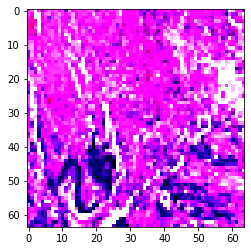

In [56]:
plt.imshow(first(torch.utils.data.DataLoader(val_ds, batch_size=50))['image'][12,:,:,:].swapaxes(0,2)) # imshow expects channel last

## Training the model

The goal of the approach here was to split the slides into small patches, get a label for each patch, and reconstruct a mask from these labelled patches to create a segmentation map. As such we neeeded a standard image classification model such as resnet.

This approach has been used with good results, and also allows us to see the potential performance of well established CNN models on the challenge. Importantly it also handles some of the issues with really large file sizes quite well.

Patch based learning is also generally applied when using UNet or similar models as well, but that also requires creating patches from the label masks.

This method does have some problems, such as reconstructing the labelled patches into masks which can be usefully mapped to the original image. I generally found the resources and libraries for creating patches for both images and masks lacking – although py-wsi is a great library it doesn't handle creating patches from masks. I wanted to extend the library to handle this capability along with the custom XML parsing I added but didn't manage to solve some of the issues.

We used a standard resnet model with a linear final layer to classify into 5 different labels:

'Normal': 0,

'nerve without tumor': 1,

'perineural invasion junction': 2,

'tumor without nerve': 3,

'nontumor without nerve': 4

In [66]:
# Model class (a)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(512, 5)
        # self.classifer = nn.Linear(512, 5)
        self.model = model
    
    def forward(self, x):
        x = self.model(x) 

        return x

In [71]:
device = torch.device("cuda:0")
model = Net().to(device)

# Experimented with different weights for the loss function
# There was a large class imbalance which was difficult to overcome, especially for label 2 which is the most important one
loss_function = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.,10.,50.,10.,10.]).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
max_epochs = 100
val_interval = 1 # Interval to run validation loop on


## Model training

We used a relatively typical pytroch training loop. Some differences seen as the data loaders return a dictionary with the images and labels.

For evaluation we looked at the overall accuracy of the model on our validation dataset every few epochs, and saved the highest accuracy model as we progressed through training.

This is a relatively crude indicator as the data is so imbalanced, and the classification we care the most about has a very small sample size – the perineural invasion junction label has only has 10 patches. Therefore it's possible to acheive a very high accuracy by only predicting label 0, normal tissue, but this would perform poorly in terms of segmentation.

In [72]:
# Training the model (c)
best_acc = -1
best_acc_epoch = -1
epoch_loss_values = []
acc_values = []

# Training loop
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )

        optimizer.zero_grad()

        # Get predictions
        outputs = model(inputs)

        # calculate loss
        loss = loss_function(outputs, labels)

        # back propagation
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Run evaluation if the val_interval is hit
    # validating the model (d)
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            prediction_count = 0
            num_correct = 0.0

            # Validation loop
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )

                # Run throug model
                val_outputs = model(val_images)

                # Check which labels had correct value
                value = torch.eq(val_outputs.argmax(dim=1), val_labels)

                prediction_count += len(value)
                num_correct += value.sum().item()

            accuracy = num_correct / prediction_count
            acc_values.append(accuracy)

            if accuracy > best_acc:
                best_acc = accuracy
                best_acc_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_acc_model.pth"))
                print("saved new best accuracy model")
            print(
                f" current epoch: {epoch + 1}"
                f" current accuracy: {accuracy:.4f}"
                f" best accuracy: {best_acc:.4f}"
                f" at epoch: {best_acc_epoch}"
            )

print(
    f"train completed, best_metric: {best_acc:.4f} "
    f"at epoch: {best_acc_epoch}")

----------
epoch 1/100
1/3, train_loss: 2.5509
2/3, train_loss: 2.4730
3/3, train_loss: 2.4905
4/3, train_loss: 2.5725
epoch 1 average loss: 2.5217
saved new best accuracy model
 current epoch: 1 current accuracy: 0.0420 best accuracy: 0.0420 at epoch: 1
----------
epoch 2/100
1/3, train_loss: 2.3969
2/3, train_loss: 2.3835
3/3, train_loss: 2.3947
4/3, train_loss: 2.4642
epoch 2 average loss: 2.4098
saved new best accuracy model
 current epoch: 2 current accuracy: 0.0468 best accuracy: 0.0468 at epoch: 2
----------
epoch 3/100
1/3, train_loss: 2.3235
2/3, train_loss: 2.3241
3/3, train_loss: 2.3165
4/3, train_loss: 2.3380
epoch 3 average loss: 2.3255
 current epoch: 3 current accuracy: 0.0422 best accuracy: 0.0468 at epoch: 2
----------
epoch 4/100
1/3, train_loss: 2.2436
2/3, train_loss: 2.2292
3/3, train_loss: 2.1706
4/3, train_loss: 2.3631
epoch 4 average loss: 2.2516
 current epoch: 4 current accuracy: 0.0422 best accuracy: 0.0468 at epoch: 2
----------
epoch 5/100
1/3, train_loss: 

## Plot the loss and accuracy

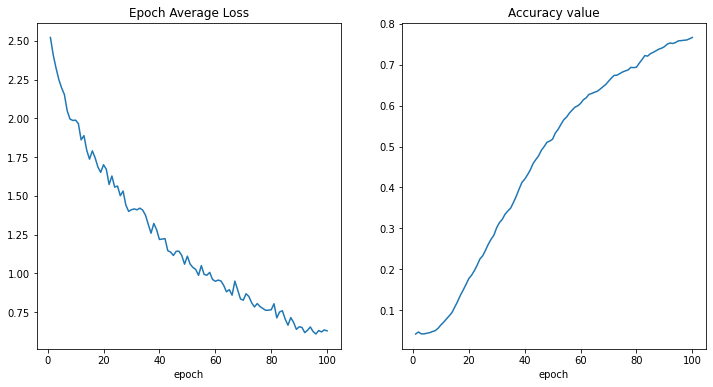

In [73]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Accuracy value")
x = [val_interval * (i + 1) for i in range(len(acc_values))]
y = acc_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

After training and validation, we should have the best model available on our validation set. We kept a test set aside to test the model on completely unseen data.

We run the test dataset through the model and print the performance on key performance indicators such as the F1-score and accuracy. We can also see how many samples there were for each label.

Generally we will see quite high performance for the label 0, normal tissue. It was difficult for the model to overcome the overfitting expected with such a unbalanced dataset.

In [74]:
# validating the model (c)
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_acc_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['image'].to(device),
            test_data['label'].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [75]:
print(classification_report(
    y_true, y_pred, target_names=['0','1','2','3','4'], digits=4))

              precision    recall  f1-score   support

           0     0.9617    0.7980    0.8722      6360
           1     0.0662    0.1389    0.0897        72
           2     0.0000    0.0000    0.0000         4
           3     0.2232    0.6786    0.3360       252
           4     0.1161    0.4068    0.1807       177

    accuracy                         0.7761      6865
   macro avg     0.2735    0.4044    0.2957      6865
weighted avg     0.9029    0.7761    0.8260      6865



The unbalanced dataset was difficult to overcome with our approach. The dataset was heavily biased towards healthy or not relevant tissue, if we were to reconstruct the patches into an image mask the segmentation would also be poor due to this. We concentrated on trying to build an accurate model and the mask rebuilding attempts are not included here.

We tried a few attempts at different weights for the loss function, different transformations including normalisation, with similar results. Performance for any label besides 'normal' was generally very poor.

Attempting the problem with UNet and patches would be an interesting avenue to try, although I imagine some of the issues with unbalanced data will persist. More extensive preprocessing techniques might be beneficial to try to make the perineural invasion more prominent compared to other features. Additionally better sampling techniques and transformations to resample the same patches with the perineural junction in it can help reduce the impact of imbalances. Addittionally some slides had artifacts such as ink smears, and our model does not implement any techniques to deal with it.